In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from collections import defaultdict

from neural_behavior_dataset import NeuralBehaviorDataset

# ------------------------------------------------------------------
# Configuration (edit as needed)
# ------------------------------------------------------------------
data_dir = Path("/media/NAS_179_2_josh_2/snu-pni-decoding/E003_12weeks_labelled_raw_data_251116")
cache_dir = Path("/media/NAS_179_2_josh_2/snu-pni-decoding/E003_12weeks_labelled_raw_data_251116/cache")
trials = ["E003_1W_Trial2_labelled_raw_data_.csv"]  # None means all trials
window_size = 2441
stride = 2441
normalization_mode = "percentile"  # 'none', 'zscore', or 'percentile'
percentile_range = (1, 99)      # Required when mode='percentile'
percentile_clip = False
activity_sigma_mult = 2.0
outlier_sigma_mult = 10.0
resting_labels = {"resting"}
include_labels = {"resting", "walking", "climbing", "standing", "grooming"}
num_windows_per_label = 50
plot_percentiles = (1, 99)     # Use raw min/max for plotting
run_timestamp = int(time.time())
output_dir = Path("/media/NAS_179_2_josh_2/snu-pni-decoding/analysis/dataloader_visualization") / f"run_{run_timestamp}"
output_dir.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------------
# Load dataset
# ------------------------------------------------------------------
dataset = NeuralBehaviorDataset(
    data_dir=data_dir,
    window_size=window_size,
    stride=stride,
    trials=trials,
    cache_dir=cache_dir,
    normalization_mode=normalization_mode,
    percentile_range=percentile_range,
    percentile_clip=percentile_clip,
    activity_sigma_mult=activity_sigma_mult,
    outlier_sigma_mult=outlier_sigma_mult,
    resting_labels=resting_labels,
    include_labels=include_labels,
    use_cache=True,
)

label_names = dataset.label_encoder.inverse_transform(np.arange(len(dataset.label_encoder.classes_)))
per_label_count = {name: 0 for name in label_names}


Filter summary:
  Signals: 137221 -> 32757 after filters
  Removed by outlier threshold: 7236
    climbing: 1135
    grooming: 902
    resting: 991
    standing: 100
    unassigned: 3421
    walking: 687
  Removed by activity threshold: 17873
    climbing: 568
    grooming: 1881
    standing: 211
    unassigned: 14911
    walking: 302
  Removed by include_labels filter: 79355
    unassigned: 79355


In [2]:
collected = []
all_values = []
label_std = {name: [] for name in label_names}

for idx in range(len(dataset)):
    signal, label_idx = dataset[idx]
    label_name = label_names[label_idx]
    if per_label_count[label_name] >= num_windows_per_label:
        continue

    per_label_count[label_name] += 1
    signal_np = signal.numpy().squeeze()
    collected.append((signal_np, label_name, per_label_count[label_name], idx))
    all_values.append(signal_np)
    label_std[label_name].append(signal_np.std())

    if all(count >= num_windows_per_label for count in per_label_count.values()):
        break

if not collected:
    raise RuntimeError("No windows gathered with current settings.")

all_values_stack = np.concatenate(all_values)
if plot_percentiles:
    y_low = float(np.nanpercentile(all_values_stack, plot_percentiles[0]))
    y_high = float(np.nanpercentile(all_values_stack, plot_percentiles[1]))
else:
    y_low = float(all_values_stack.min())
    y_high = float(all_values_stack.max())

print(f"Using global y-limits: [{y_low:.3f}, {y_high:.3f}]")
for label_name, std_values in label_std.items():
    if std_values:
        print(f"Label {label_name}: mean std = {np.mean(std_values):.4f}")


Using global y-limits: [-0.028, 1.026]
Label climbing: mean std = 0.1498
Label grooming: mean std = 0.2078
Label resting: mean std = 0.1263
Label standing: mean std = 0.1208
Label walking: mean std = 0.1852


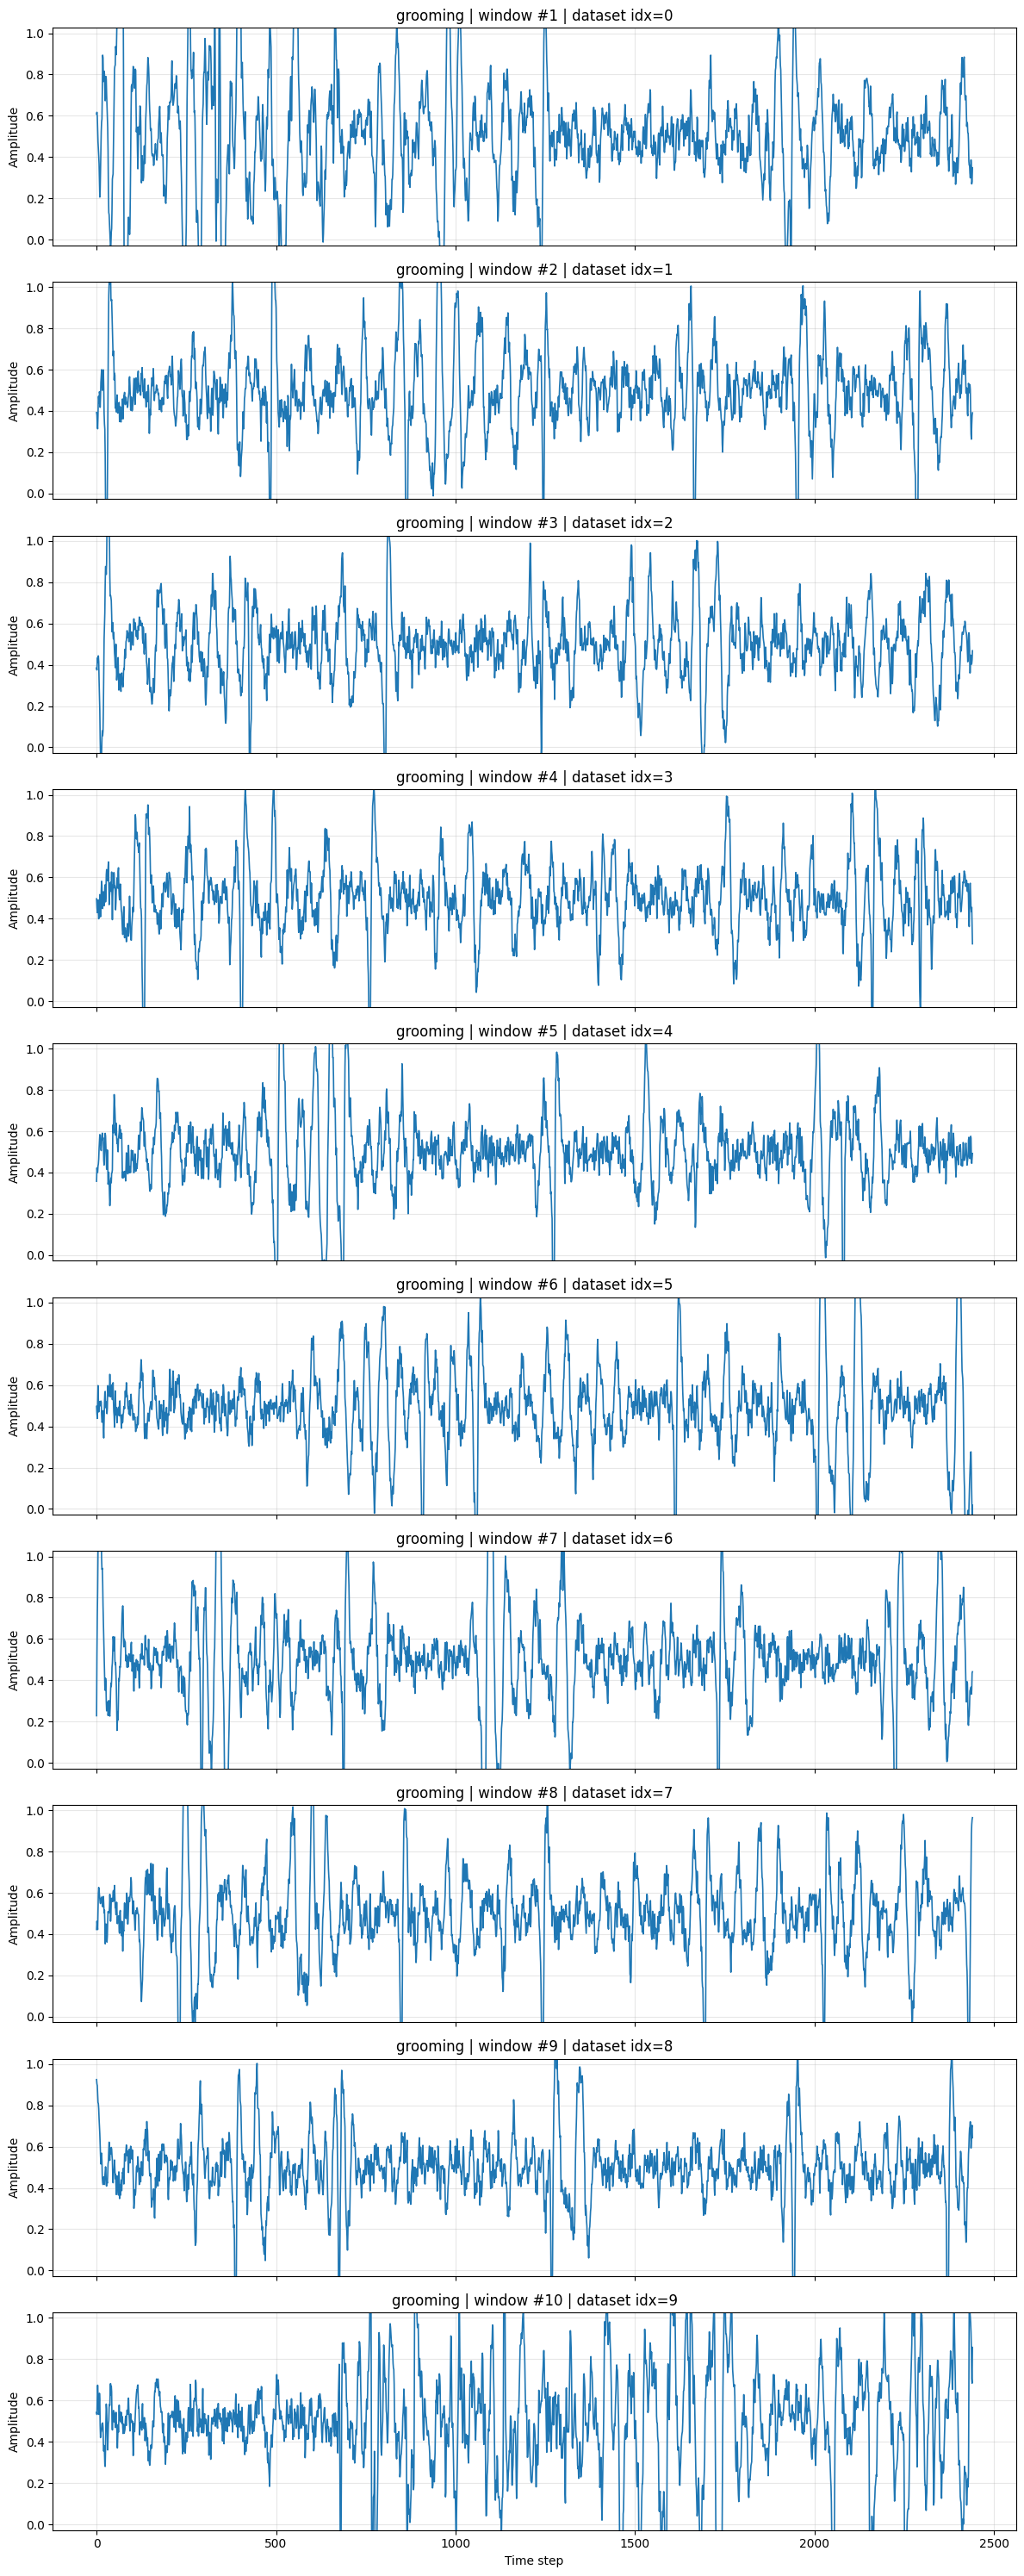

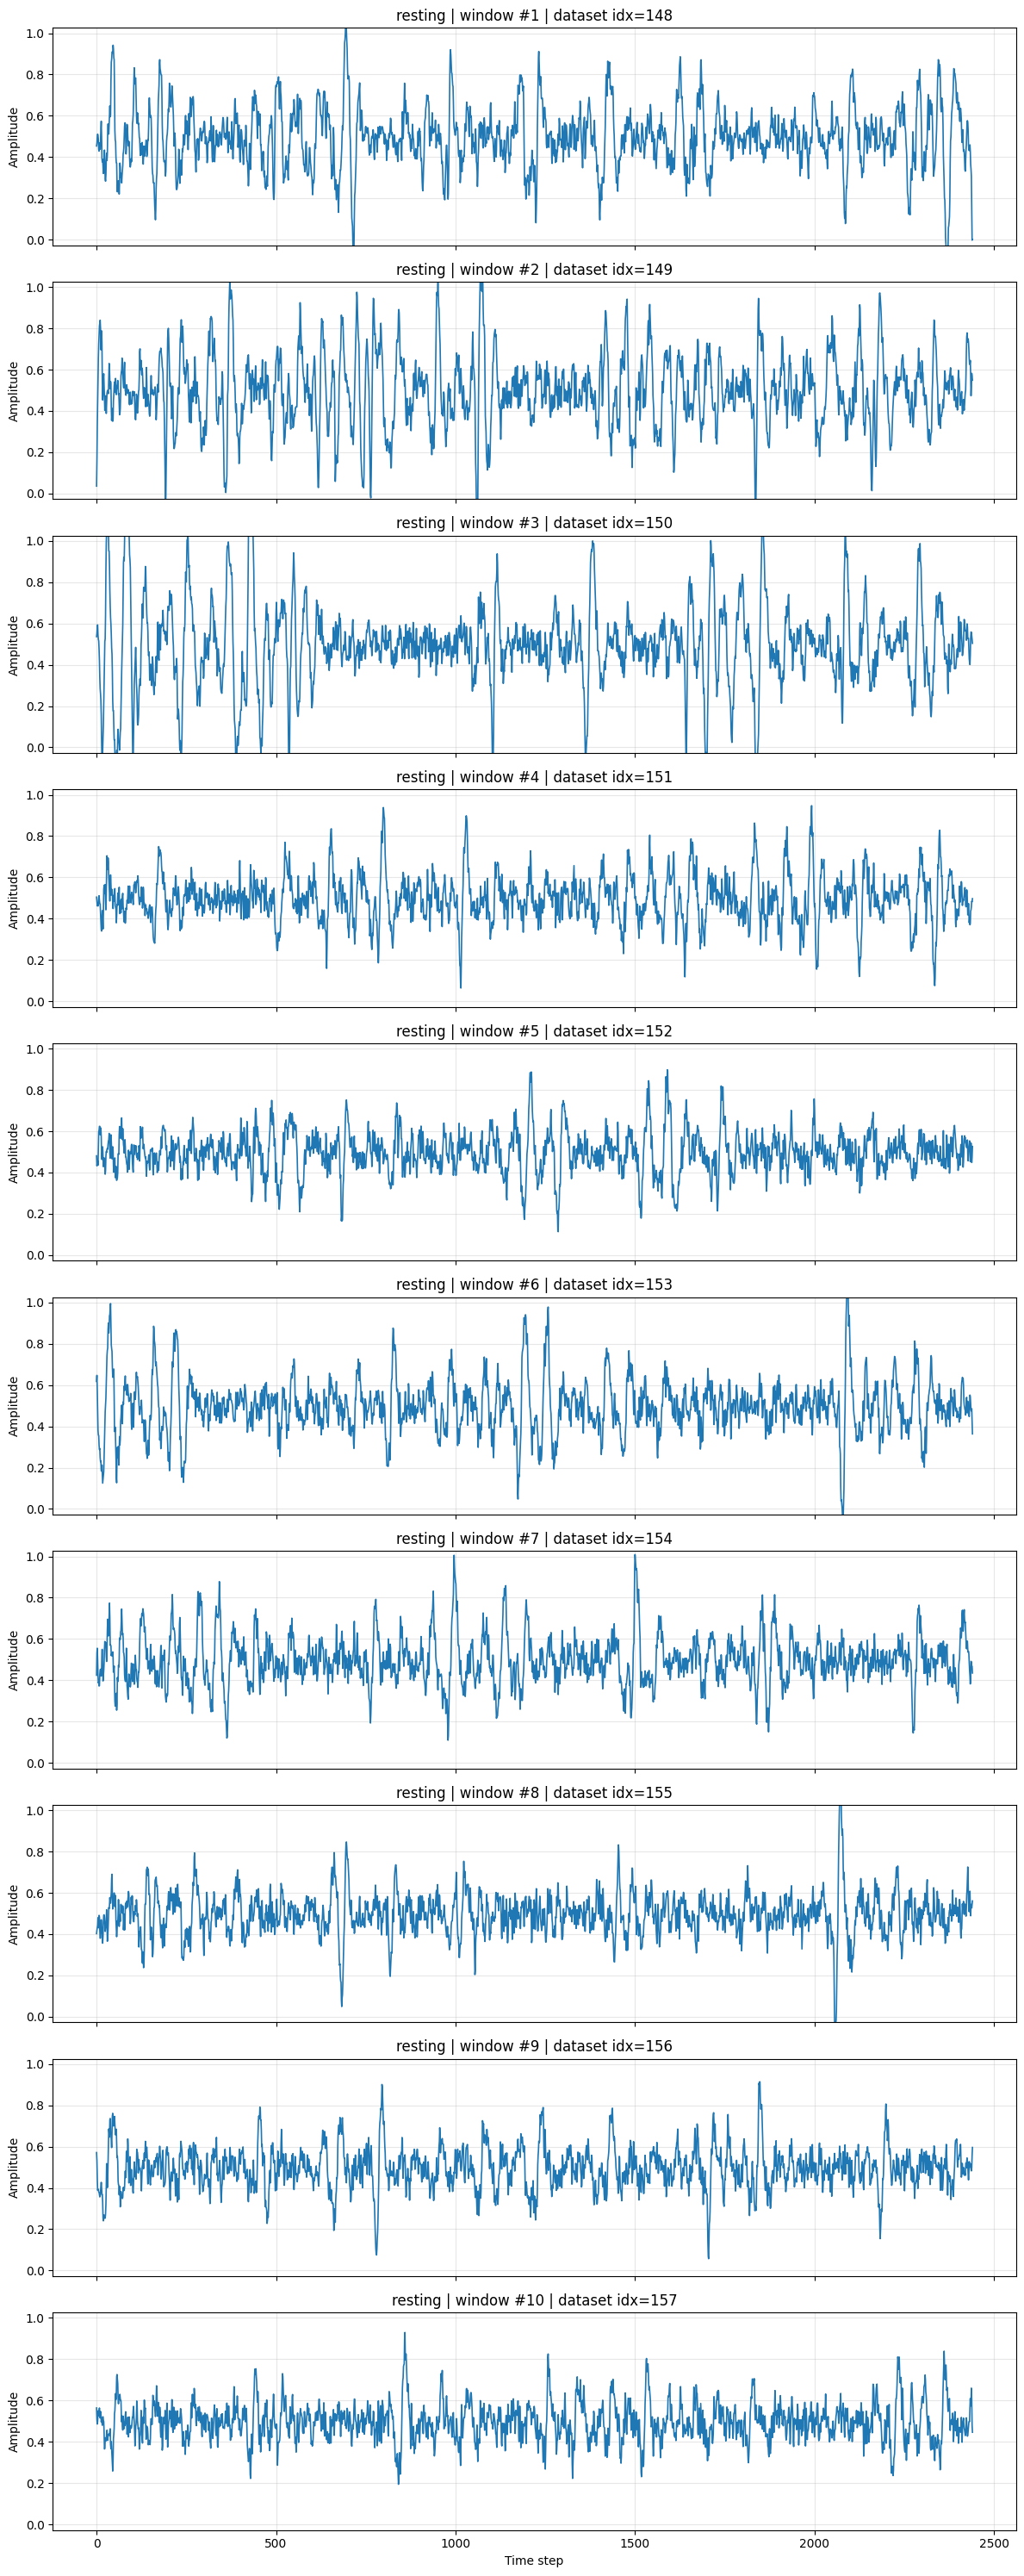

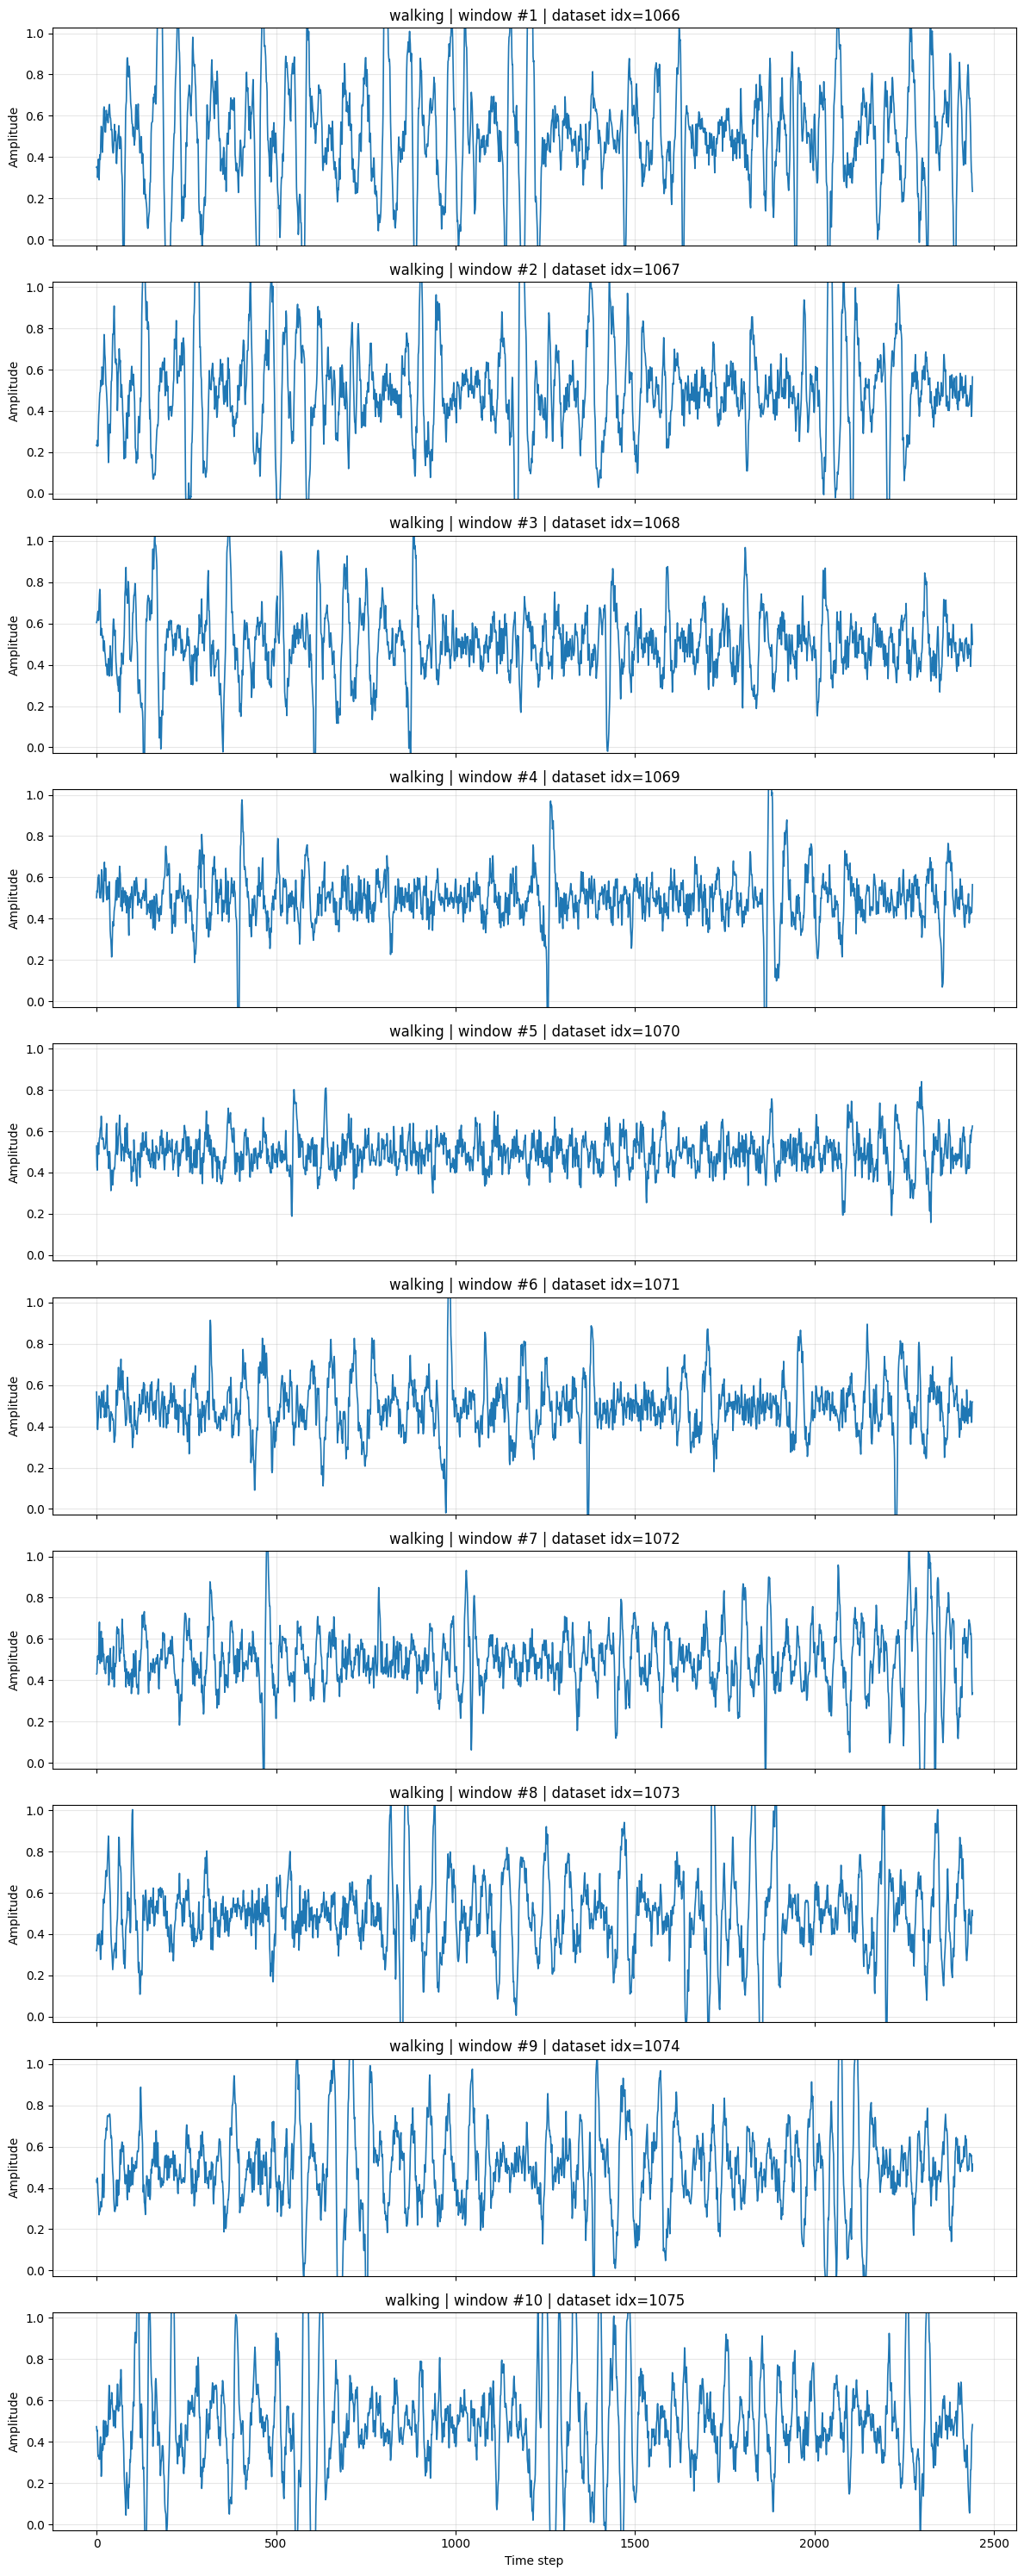

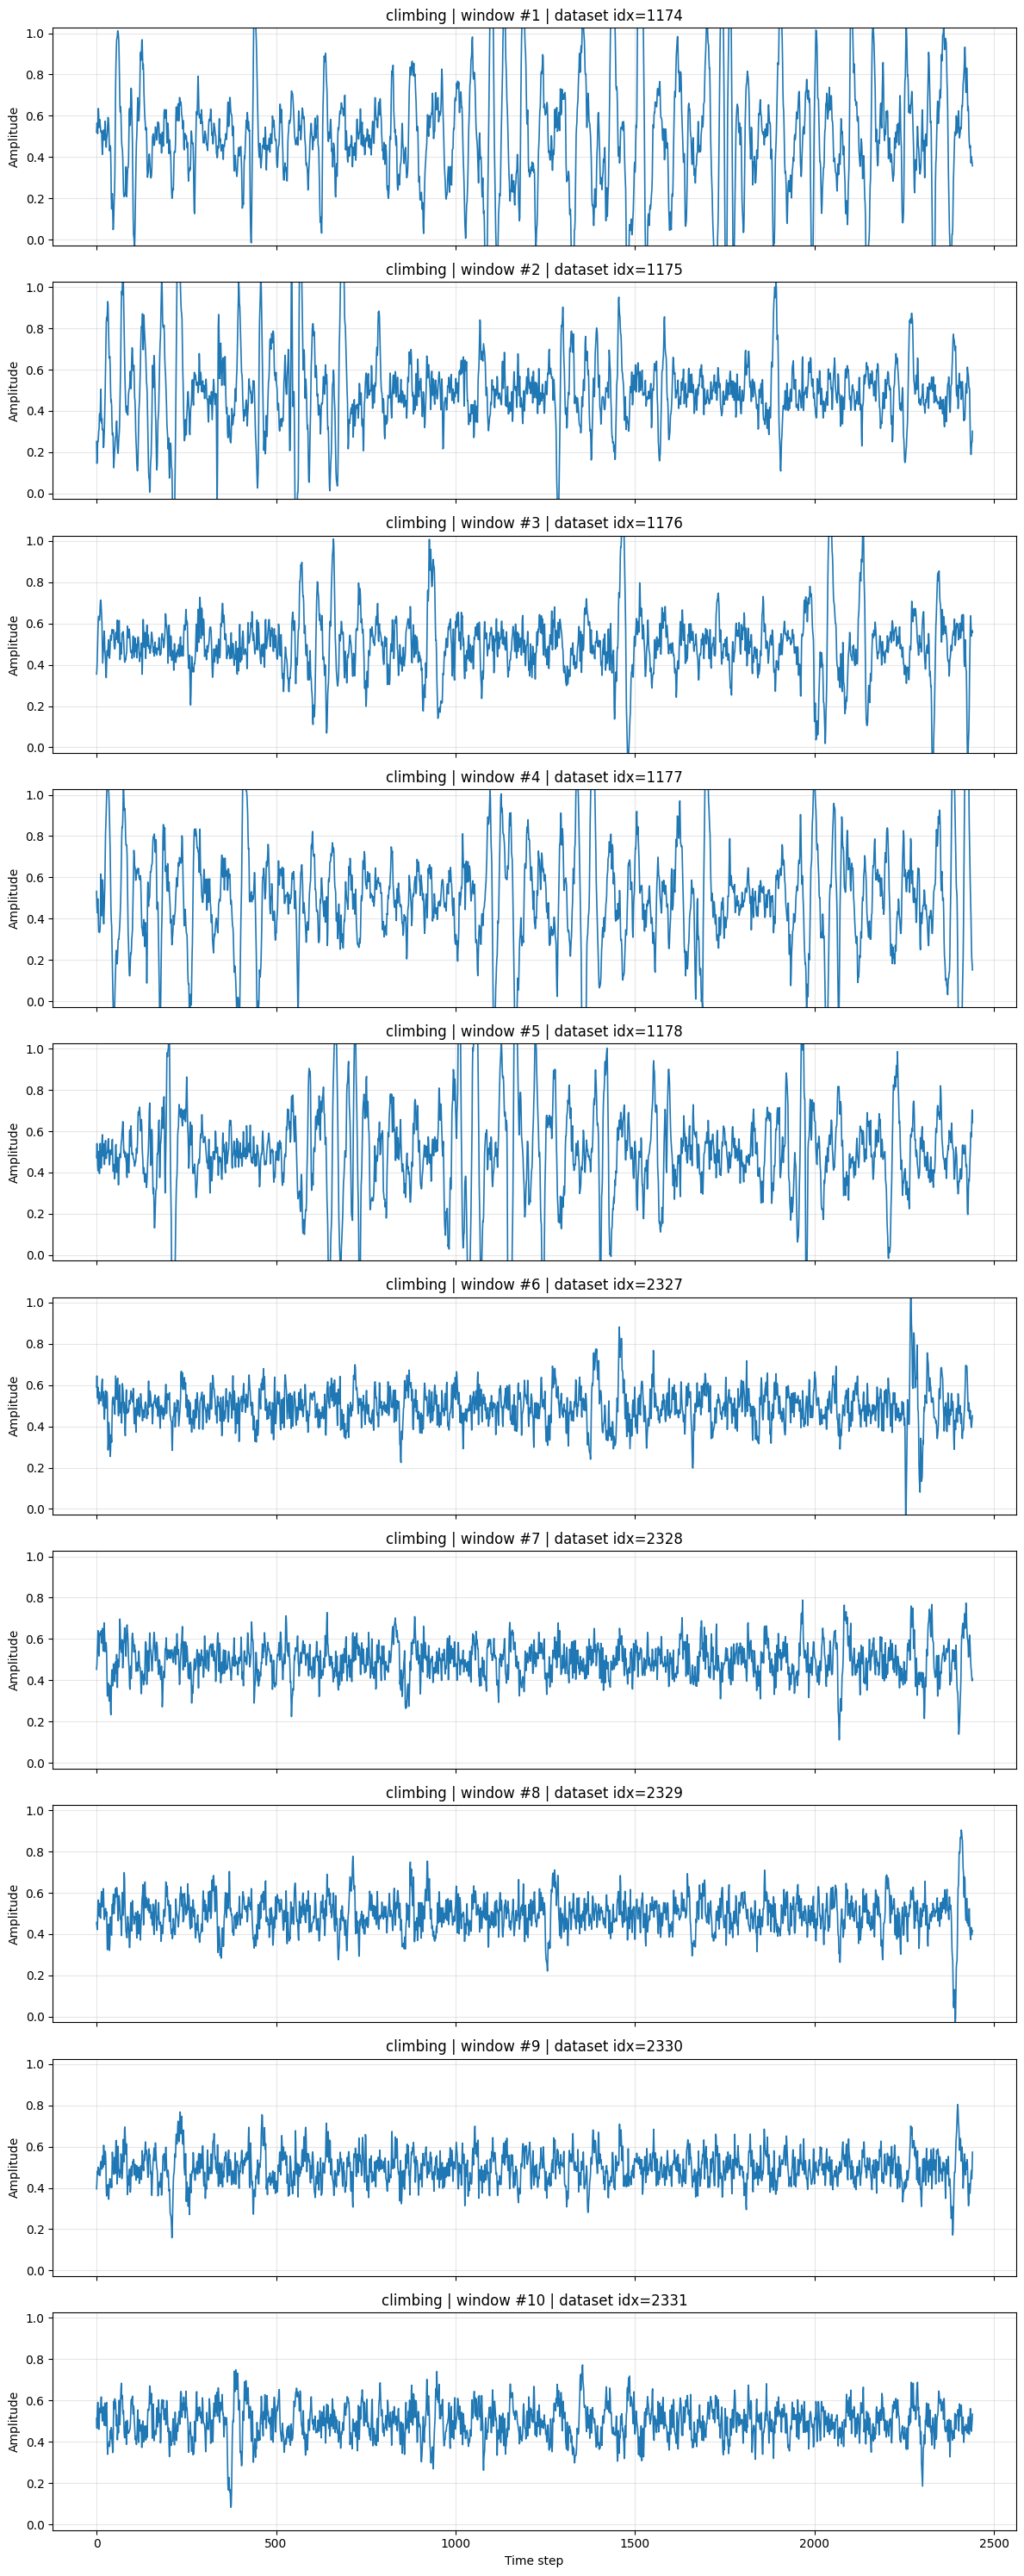

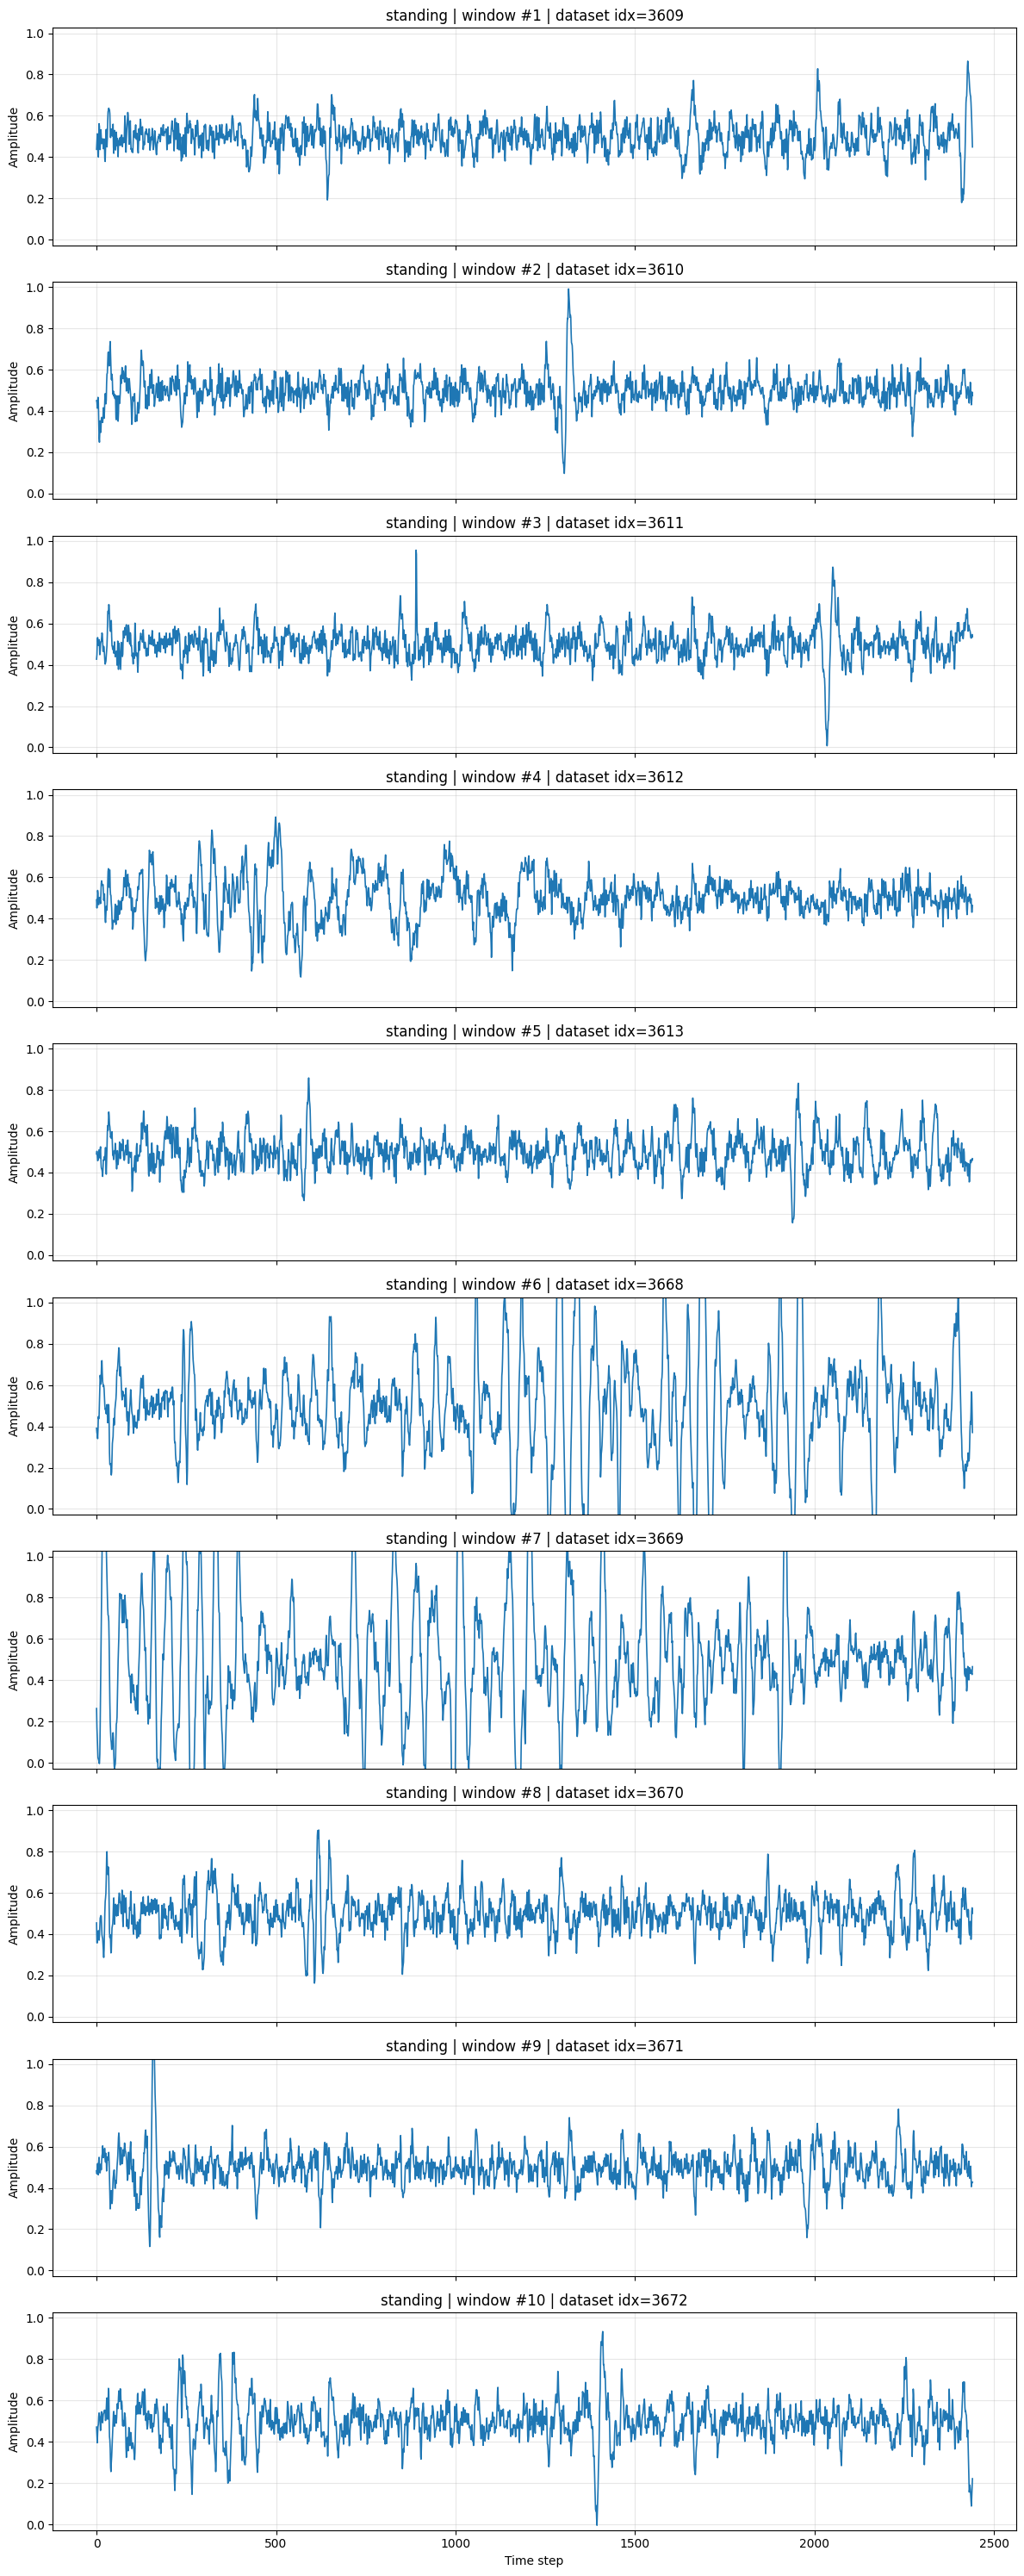

Saved figures:
  grooming: 10 window(s)
  resting: 10 window(s)
  walking: 10 window(s)
  climbing: 10 window(s)
  standing: 10 window(s)


In [3]:
by_label = defaultdict(list)
for signal_np, label_name, window_idx, dataset_idx in collected:
    by_label[label_name].append((signal_np, window_idx, dataset_idx))

for label_name, windows in by_label.items():
    if not windows:
        continue

    fig, axes = plt.subplots(len(windows), 1, figsize=(12, 3 * len(windows)), sharex=True)
    if len(windows) == 1:
        axes = [axes]

    for ax, (signal_np, window_idx, dataset_idx) in zip(axes, windows):
        ax.plot(signal_np, linewidth=1.2)
        ax.set_ylim(y_low, y_high)
        ax.set_ylabel("Amplitude")
        ax.grid(True, alpha=0.3)
        ax.set_title(f"{label_name} | window #{window_idx} | dataset idx={dataset_idx}")

    axes[-1].set_xlabel("Time step")
    fig.tight_layout()
    display(fig)

    outfile = output_dir / f"label-{label_name}_stack.png"
    fig.savefig(outfile, dpi=150)
    plt.close(fig)

print("Saved figures:")
for label_name, windows in by_label.items():
    print(f"  {label_name}: {len(windows)} window(s)")
